In [ ]:
import math
import random
import matplotlib.pyplot as plt

**Read tsplib files**

In [ ]:
def read_tsplib(filename):
    coords = []
    with open(filename, 'r') as file:
        in_section = False
        for line in file:
            line = line.strip()
            if line == 'NODE_COORD_SECTION':
                in_section = True
                continue
            if line == 'EOF':
                break
            if in_section:
                parts = line.split()
                if len(parts) >= 3:
                    x, y = float(parts[1]), float(parts[2])
                    coords.append((x, y))
    return coords

** Distance functions **
*   euclidean_distance applys to Berlin52 and Eil101
*   haversine_distance applys to Ulysses22



In [ ]:
def euclidean_distance(a, b):
    return math.hypot(a[0] - b[0], a[1] - b[1])

In [ ]:
def haversine_distance(a, b):
    R = 6371
    lat1, lon1 = math.radians(a[0]), math.radians(a[1])
    lat2, lon2 = math.radians(b[0]), math.radians(b[1])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a_h = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    return R * 2 * math.asin(math.sqrt(a_h))

In [ ]:
def total_distance(route, coords, dist_func):
    return sum(dist_func(coords[route[i]], coords[route[(i + 1) % len(route)]]) for i in range(len(route)))

**Initilization by Nearest Neighbor method**

In [ ]:
# Nearest Neighbor Intialization
def nearest_neighbor_route(coords, start=0):
    n = len(coords)
    unvisited = set(range(n))
    route = [start]
    unvisited.remove(start)
    while unvisited:
        last = route[-1]
        next_city = min(unvisited, key=lambda city: euclidean_distance(coords[last], coords[city]))
        route.append(next_city)
        unvisited.remove(next_city)
    return route

**Neighborhood Structure: Apply 2-opt local search**

In [ ]:
#2-opt local search
def two_opt(route, coords, dist_func):
    best = route
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route) - 1):
                if j - i == 1:
                    continue
                new_route = best[:]
                new_route[i:j] = best[j - 1:i - 1:-1]
                if total_distance(new_route, coords, dist_func) < total_distance(best, coords, dist_func):
                    best = new_route
                    improved = True
        route = best
    return best

**Perturbation mechanism: enhance diversification**

In [ ]:
def perturb_solution(route, strength):
    """Randomly swap 'strength' pairs in the solution to diversify search."""
    perturbed = route[:]
    n = len(route)
    for _ in range(strength):
        i, j = random.sample(range(1, n), 2)
        perturbed[i], perturbed[j] = perturbed[j], perturbed[i]
    return perturbed

**Main Tabu Search metaheuristics**

In [ ]:
def tabu_search(coords, dist_func, iterations=1000, tabu_size=100, stagnation_limit=150):
    n = len(coords)
    current = nearest_neighbor_route(coords, start=0)
    best = current[:]
    best_dist = total_distance(best, coords, dist_func)
    best_history = [best_dist]
    tabu_list = []
    no_improvement_counter = 0

    for iter in range(iterations):
        neighborhood = []
        for i in range(1, n - 1):  # keep 0 fixed
            for j in range(i + 1, n):
                neighbor = current[:]
                neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
                move = (i, j)
                dist = total_distance(neighbor, coords, dist_func)
                if move not in tabu_list or dist < best_dist:  # aspiration criterion
                    neighborhood.append((neighbor, move, dist))

        if not neighborhood:
            break

        neighborhood.sort(key=lambda x: x[2])
        current, move, dist = neighborhood[0]

        if dist < best_dist:
            best = current[:]
            best_dist = dist
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        tabu_list.append(move)
        if len(tabu_list) > tabu_size:
            tabu_list.pop(0)

        # Periodic 2-opt refinement
        if iter % 100 == 0 and iter > 0:
            refined = two_opt(current, coords, dist_func)
            refined_dist = total_distance(refined, coords, dist_func)
            if refined_dist < best_dist:
                best = refined
                best_dist = refined_dist
                current = refined
                no_improvement_counter = 0

        # Adaptive diversification triggered by stagnation
        if no_improvement_counter >= stagnation_limit:
            print(f"Iter {iter}: Diversification triggered due to stagnation.")
            strength = max(3, int(0.05 * n))  # adaptive perturbation strength (5% of problem size)
            current = perturb_solution(best, strength)
            current = two_opt(current, coords, dist_func)  # immediate recovery
            no_improvement_counter = 0
            tabu_list.clear()  # optional reset

        best_history.append(best_dist)

        if iter % 50 == 0:
            print(f"Iter {iter}: best distance = {best_dist:.2f}")

    return best, best_dist, best_history

In [ ]:
def plot_route(route, coords):
    xs = [coords[i][0] for i in route + [route[0]]]
    ys = [coords[i][1] for i in route + [route[0]]]
    plt.figure(figsize=(8,6))
    plt.plot(xs, ys, 'o-', color='blue')
    plt.title("Best TSP Route Found by Tabu Search")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

In [ ]:
filename ="ulysses22.tsp" #can change to Eil101 or Berlin52 datasets

In [ ]:
coords = read_tsplib(filename)

In [ ]:
# Choose distance function
if "ulysses" in filename.lower():
    dist_func = haversine_distance
else:
    dist_func = euclidean_distance

In [ ]:
# Run Tabu Search
best_route, best_dist, history = tabu_search(coords, dist_func, iterations=500, tabu_size=100)

Iter 0: best distance = 792.62
Iter 50: best distance = 699.70
Iter 100: best distance = 685.04
Iter 150: best distance = 685.04
Iter 200: best distance = 685.04
Iter 250: Diversification triggered due to stagnation.
Iter 250: best distance = 685.04
Iter 300: best distance = 682.63
Iter 350: best distance = 681.56
Iter 400: best distance = 669.72
Iter 450: best distance = 669.72


In [ ]:
print(f"Best route distance: {best_dist:.2f}")

Best route distance: 669.72


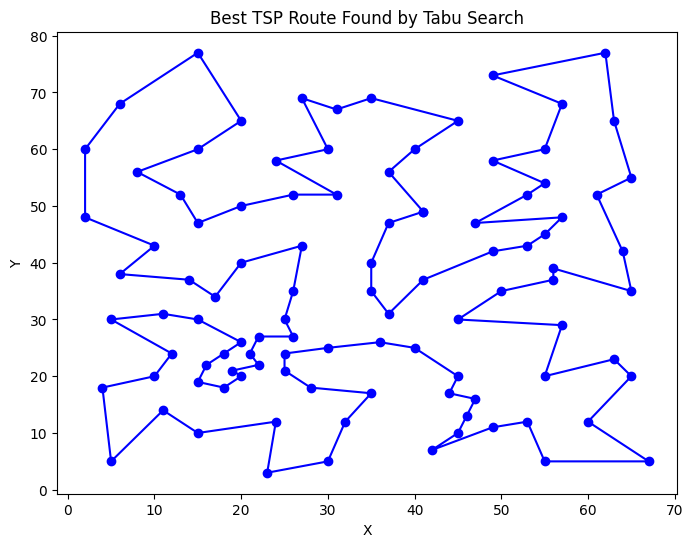

In [ ]:
plot_route(best_route, coords)

In [ ]:
# Print the final route
route_with_return = best_route + [best_route[0]]
route_str = '-'.join(str(city + 1) for city in route_with_return)
print("Best route (1-based, starts and ends at node 1):")
print(route_str)

Best route (1-based, starts and ends at node 1):
1-69-27-101-53-28-76-77-3-79-50-33-81-51-9-71-66-65-35-34-78-29-24-68-80-12-26-54-4-55-25-39-67-23-56-75-41-22-74-72-73-21-40-58-13-95-97-87-2-57-15-43-42-14-44-38-86-16-61-17-84-5-99-93-85-91-100-37-98-92-59-96-94-6-89-52-18-60-83-45-8-46-36-49-64-11-19-47-48-82-7-88-31-62-10-63-90-32-20-30-70-1


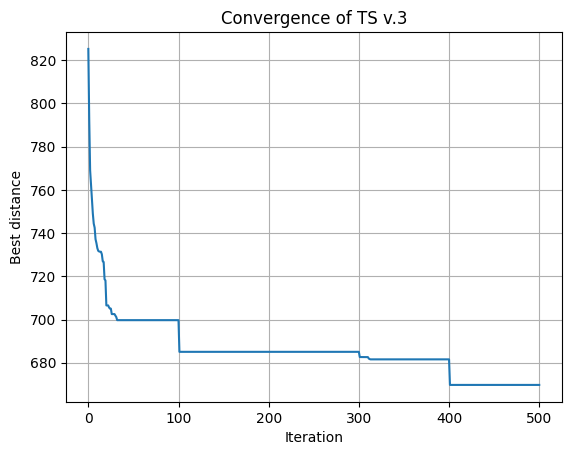

In [ ]:
# Draw convergence plot
import matplotlib.pyplot as plt
plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Best distance")
plt.title("Convergence of TS v.3")
plt.grid(True)
plt.show()